In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import seaborn as sns
import json, os, pickle
from collections import defaultdict
import nupack
import sklearn
from scipy import stats


from tqdm import tqdm
import itertools

from nnn import util, fileio, mupack, plotting, modeling
import nnn.motif_fit as mf
import wandb

# suppress warnings 
import warnings
warnings.filterwarnings("ignore")

from nnn import train_nn as tnn

In [2]:
fixed_pclass = ['hairpin_size', 'interior_size', 'bulge_size', 'hairpin_triloop', 'hairpin_tetraloop', 'terminal_mismatch', 'stack']
config = dict(
    use_train_set_ratio = 1.,
    fit_method = 'svd',
    feature_method = 'get_nupack_feature_list',
    fit_intercept=False, 
    symmetry=False,
    fix_some_coef=True,
    fixed_pclass = fixed_pclass,
    test_mode = 'val', # {'val', 'test'}
    use_model_from = 'json', # {'lr_dict', 'json'}
    )

In [8]:
fileio.write_json(dict(wandb_config), './models/test.json')

In [18]:
fixed_pclass = []#['hairpin_size', 'interior_size', 'bulge_size', 'hairpin_triloop', 'hairpin_tetraloop', 'terminal_mismatch', 'stack']
config = dict(
    use_train_set_ratio = 1.0,
    fit_method = 'svd',
    feature_method = 'get_feature_list',
    fit_intercept=False, 
    symmetry=False,
    sep_base_stack=True,
    fix_some_coef=True,
    fixed_pclass = fixed_pclass,
    test_mode = 'val', # {'val', 'test'}
    use_model_from = 'lr_dict', # {'lr_dict', 'json'}
    )

feats (27732, 1338) Index(['A+A+T+T_(+(+)+)', 'A+C+G+T_(+(+)+)', 'A+G+C+T_(+(+)+)'], dtype='object')
fixed_feature_names: []
Empty DataFrame
Columns: [dH]
Index: []
[]
Empty DataFrame
Columns: [dG]
Index: []
[]


n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


{'dH': LinearRegressionSVD(param='dH'), 'dG': LinearRegressionSVD()}

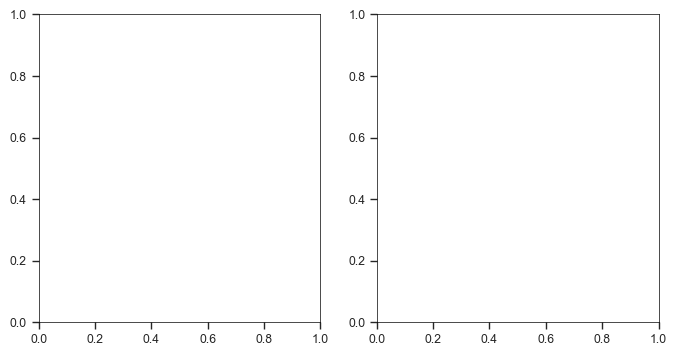

In [19]:
tnn.model_pipeline(config)

In [3]:
myrange = np.arange(0.2, 1.2, .2)
myrange

array([0.2, 0.4, 0.6, 0.8, 1. ])

wandb: Currently logged in as: keyuxi. Use `wandb login --relogin` to force relogin


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


feats (27732, 178) Index(['bulge_size#1', 'bulge_size#2', 'hairpin_loop_mid#A'], dtype='object')
fixed_feature_names: ['bulge_size#1', 'bulge_size#2', 'hairpin_size#3', 'hairpin_size#4', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', 'hairpin_size#20', 'interior_size#2', 'interior_size#4', 'stack#AATT', 'stack#ACGT', 'stack#AGCT', 'stack#ATAT', 'stack#CATG', 'stack#CCGG', 'stack#CGCG', 'stack#CTAG', 'stack#GATC', 'stack#GCGC', 'stack#GGCC', 'stack#GTAC', 'stack#TATA', 'stack#TCGA', 'stack#TGCA', 'stack#TTAA']
                           dH
bulge_size#1              0.0
bulge_size#2              0.0
bulge_size#3              0.0
bulge_size#4              0.0
bulge_size#5              0.0
...                       ...
hairpin_tetraloop#CCTTGG  0.0
hairpin_tetraloop#GCTTGC  0.0
hairpin_tetraloop#GCTTGT  0.0
hairpin_tetraloop#TCTTGA  0.0
hairpin_tetraloop#TCTTGG  0.0

[352 rows x 1 columns]
['bulge_size#1', 'bulge_size#2', 'hairpin_size#11', 'hairpin_size#14', 'hairpin_size#17', '

n_feat,▁
n_fixed_feat,▁
train_dG_mae,▁
train_dG_rsqr,▁
train_dH_mae,▁
train_dH_rsqr,▁
val_Tm_adjusted_mae-all,▁
val_Tm_adjusted_mae-arr,▁
val_Tm_adjusted_mae-lit_uv,▁
val_Tm_adjusted_mae-ov,▁
val_Tm_adjusted_rmse-all,▁


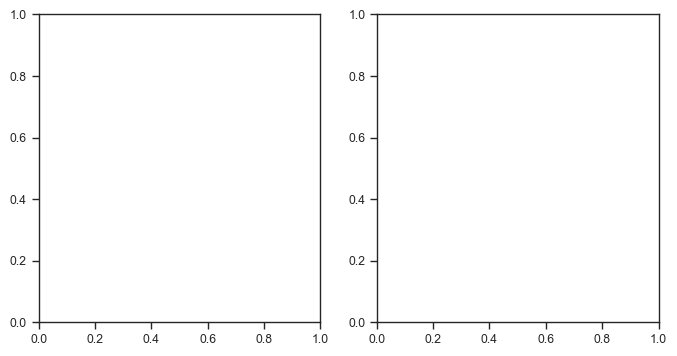

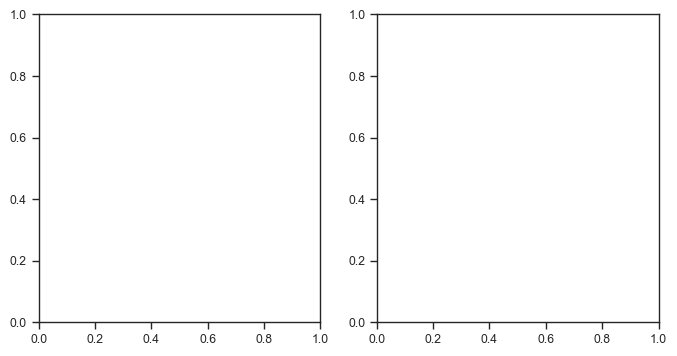

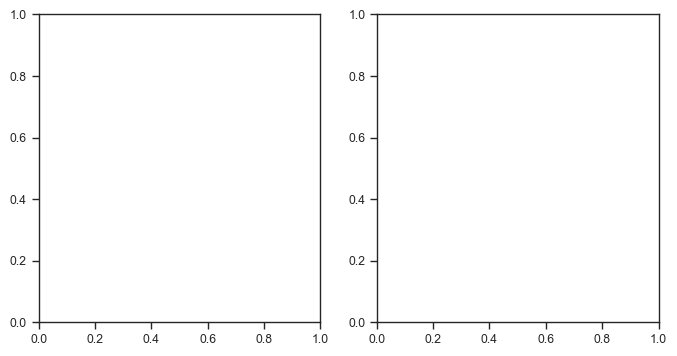

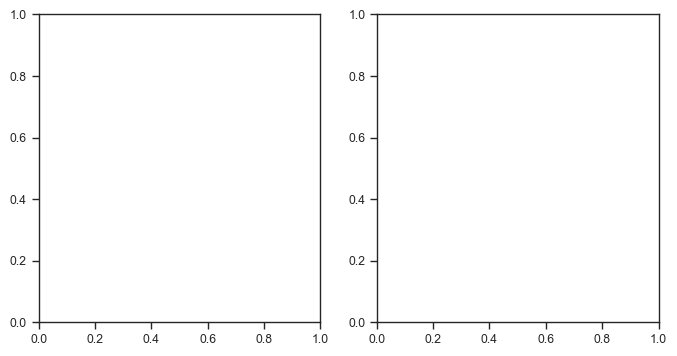

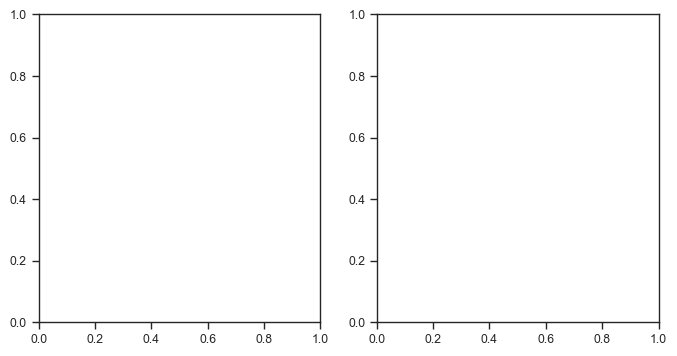

In [4]:
for ratio in myrange:
    config.update(dict(use_train_set_ratio=ratio))
    tnn.model_pipeline(config)

## Tests

In [70]:
mydata = tnn.MyData(config)
mydata.load_everything()

In [71]:
mydata.prepare_val_df()['lit_uv'].RefSeq[0][0]

'GATATAGCAAAATTCTAAGTTAATA'

In [49]:
# FUNCTION TEST
metric_dict = dict(
    all=dict(
        Tm=dict(rmse=.3),
    ),
    arr=dict(
        Tm=dict(rmse=.2),
        dH=dict(mae=.1),
        dG=dict(corr=.4)
    ),
    ov=dict(
        Tm=dict(rmse=.5)
    )
)
tnn.flatten_metric_dict(metric_dict)

{'val_Tm_rmse-all': 0.3,
 'val_Tm_rmse-arr': 0.2,
 'val_dH_mae-arr': 0.1,
 'val_dG_corr-arr': 0.4,
 'val_Tm_rmse-ov': 0.5}

In [148]:
json_file = './models/dna04.json'
tnn.test(config, json_file=json_file, debug=True,
         save_val_result_df=True, save_metric_json=True)

Must call `wandb.init()` first


{'all': {'Tm': defaultdict(None,
              {'bias': 2.9661754466208308,
               'corr': 0.793026549915973,
               'rmse': 7.1620228136935244,
               'adjusted_rmse': 6.518924298051803,
               'mae': 5.892052892391525,
               'adjusted_mae': 5.187633316054081})},
 'arr': {'Tm': defaultdict(None,
              {'bias': 2.1660371069307516,
               'corr': 0.8959452233637897,
               'rmse': 8.990712948240732,
               'adjusted_rmse': 8.725892651704045,
               'mae': 8.017791998472129,
               'adjusted_mae': 7.956103122148103}),
  'dH': defaultdict(None,
              {'bias': -18.24327473438205,
               'corr': 0.9221060003295893,
               'rmse': 18.60773231164046,
               'adjusted_rmse': 3.664782223751652,
               'mae': 18.243274734382048,
               'adjusted_mae': 2.9590951856279553}),
  'dG': defaultdict(None,
              {'bias': -0.7781412594804302,
               'cor

In [127]:
val_kwargs = dict(
    sodium = 'varied',
    model_kwargs={'DNA_conc': val_df['DNA_conc'].values}
)
seq_list, struct_list, sodium, model_kwargs = modeling.get_model_prediction(
                val_df,
                model='nupack', 
                model_param_file=json_file,
                **val_kwargs
            )

In [126]:
modeling.run_nupack(seq_list, struct_list, sodium, json_file, model_kwargs)

,dH,Tm,dG_37
0,NaN,56.388872,NaN
1,NaN,60.447325,NaN
2,NaN,57.092821,NaN
3,NaN,56.638673,NaN
4,NaN,58.732291,NaN


# Results

In [59]:
import pandas as pd 
import wandb
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("keyuxi/NN")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

# runs_df.to_csv("project.csv")

In [60]:
runs_df

,summary,config,name
0,"{'val_dG_bias-arr': 2.7917988408617327, 'val_T...","{'symmetry': False, 'test_mode': 'val', 'fit_m...",chilling-mausoleum-46
1,"{'val_Tm_mae-lit_uv': 6.661954159766046, 'val_...","{'symmetry': False, 'test_mode': 'val', 'fit_m...",ghostly-skeleton-45
2,"{'val_Tm_mae-arr': 208.51530143276193, 'val_dH...","{'symmetry': False, 'test_mode': 'val', 'fit_m...",supernatural-warlock-44
3,"{'_wandb': {'runtime': 463}, '_runtime': 464.9...","{'symmetry': False, 'test_mode': 'val', 'fit_m...",spooky-goblin-43
4,"{'train_dH_mae': 6.245854998043675, 'train_dH_...","{'symmetry': False, 'test_mode': 'val', 'fit_m...",scary-treat-42
5,"{'val_Tm_rmse-lit_uv': 7.225930631707623, 'val...","{'symmetry': False, 'test_mode': 'val', 'fit_m...",evil-sorcery-41
6,{'val_Tm_adjusted_rmse-lit_uv': 11.09348009030...,"{'symmetry': False, 'test_mode': 'val', 'fit_m...",enchanted-vampire-40
7,"{'n_fixed_feat': 0, 'train_dG_mae': 0.42332324...","{'symmetry': False, 'test_mode': 'val', 'fit_m...",moonlit-mausoleum-39
8,"{'val_Tm_adjusted_mae-arr': 5.415205181640467,...","{'symmetry': False, 'test_mode': 'val', 'fit_m...",moonlit-orb-38
9,"{'val_dH_mae-arr': 5.124491731488668, 'val_Tm_...","{'symmetry': False, 'test_mode': 'val', 'fit_m...",enchanted-whisper-37


In [5]:
wandb_df = pd.read_csv('./data/wandb/wandb_export_2023-10-31T20_06_05.100-07_00.csv')

In [9]:
wandb_df.Tags

0             NaN
1     nupack_test
2     nupack_test
3             NaN
4     nupack_test
5             NaN
6     nupack_test
7     nupack_test
8     nupack_test
9             NaN
10    nupack_test
11    nupack_test
12            NaN
13    nupack_test
14    nupack_test
15            NaN
16            NaN
Name: Tags, dtype: object

In [11]:
query = 'Tags == "nupack_test"'
wandb_df.query(query)

,Name,State,Notes,Created,Tags,feature_method,fixed_pclass,sep_base_stack,use_model_from,use_train_set_ratio,...,val_dG_mae-arr,val_dG_rmse-arr,val_dH_adjusted_mae-arr,val_dH_adjusted_rmse-arr,val_dH_bias-arr,val_dH_corr-arr,val_dH_mae-arr,val_dH_rmse-arr,dG_intercept,dH_intercept
1,vague-mountain-52,finished,-,2023-11-01T02:52:27.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,1.0,...,2.791837,2.889194,6.360076,8.159551,18.652429,0.706253,18.669692,20.359061,NaN,NaN
2,ghostly-skeleton-45,finished,-,2023-10-31T23:11:13.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,0.9,...,2.694723,2.794994,6.356110,8.161822,18.479066,0.706509,18.502945,20.201268,NaN,NaN
4,logical-wood-51,finished,-,2023-11-01T02:44:15.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,0.8,...,2.838056,2.933225,6.404810,8.211418,19.086837,0.702890,19.102520,20.778227,NaN,NaN
6,supernatural-warlock-44,finished,-,2023-10-31T23:02:53.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,0.7,...,2.675603,2.778400,6.510224,8.354189,14.843033,0.695753,14.942734,17.032561,NaN,NaN
7,apricot-frost-50,finished,-,2023-11-01T02:36:02.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,0.6,...,2.739660,2.838544,6.381573,8.204774,17.026548,0.702182,17.058942,18.900308,NaN,NaN
8,spooky-goblin-43,finished,-,2023-10-31T22:55:03.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,0.5,...,2.732862,2.833166,6.494628,8.325717,16.097329,0.695749,16.151114,18.122957,NaN,NaN
10,likely-haze-49,finished,-,2023-11-01T02:28:01.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,0.4,...,2.554343,2.663783,6.589009,8.414485,18.687560,0.690740,18.714836,20.494595,NaN,NaN
11,scary-treat-42,finished,-,2023-10-31T22:47:07.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,0.3,...,2.928712,3.027609,6.385246,8.217143,13.524066,0.706417,13.696656,15.824721,NaN,NaN
13,eager-galaxy-48,finished,-,2023-11-01T02:20:05.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,0.2,...,2.154613,2.286846,6.793244,8.687698,20.131928,0.678357,20.153905,21.926482,NaN,NaN
14,evil-sorcery-41,finished,-,2023-10-31T22:39:20.000Z,nupack_test,get_nupack_feature_list,"[""hairpin_size"",""interior_size"",""bulge_size"",""...",NaN,json,0.1,...,0.907161,1.113955,6.446095,8.218293,2.396291,0.707993,6.467395,8.560523,NaN,NaN


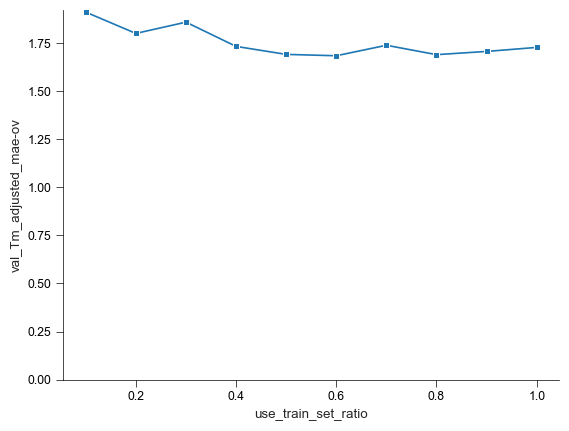

In [16]:
fig, ax = plt.subplots()
sns.lineplot(data=wandb_df.query(query), 
             x='use_train_set_ratio', y='val_Tm_adjusted_mae-ov',
            ax=ax, marker='s')
# ax.set_ylim(bottom=0, top=1)
ax.set_ylim(bottom=0)
plotting.beutify(ax)
util.save_fig('./fig/Fig4/mae.pdf')